In [60]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time

In [61]:
#Defining the input axes
# Note: the boundaries for the control actions are the actuation constraints imposed by the physics of the robots

control_space_size = 3  # Three possible inputs for each control axis

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size)) 
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size))
time_step = 0.033 # Robotarium time-step (from the documentation)

In [62]:
def model_step(x,velocities,time_step):
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

next_state = model_step([0, 0],[U_space_1[0],U_space_2[0]],time_step)
print(f"Next state {next_state}")
cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
f = st.multivariate_normal(next_state.reshape((2,)),cov) #f(x_k|u_k,x_k-1)


Next state [[-0.0165]
 [-0.0165]]


In [63]:
# This function performs a "model" step using the documented dynamics
# Note: from the viewpoint of the controller the dynamics is not necesarily known
def model_step(x,velocities,time_step):
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

#Get the value of a Gaussian pf at a given point *****?
def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf


##### WP0: formalize the control problem #####

# Task: reverse engineer the cost function used by the robots. What is the problem formulation? 
#      Is the one below a good cost for the task? Create a heatmap to visualize the cost 

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

##### WP1: fill-in the code for the function below.
#         The function needs to return the optimal action sampled from the optimal policy.
#         The action is used in the simulation loop #####

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf q(u_k|x_k-1)
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov) #p(x_k|u_k,x_k-1)
                # Task: what do the next two lines do?
                # Estrae 20 campioni dalla distribuzione p(x_k|u_k,x_k-1)
                N_samples = 20
                next_sample = f.rvs(N_samples) 

                # Task: what do the next three lines do?
                # Calcola una stima del valore atteso del costo nello stato successivo rispetto alla funzione f(x_k|x_k-1,u_k) usando 20 campioni
                cost=0
                #lnp = 0
                for k in range(N_samples):
                    cost += state_cost(next_sample[k,:],goal_points,obs_points)/N_samples
                    #lnp += np.log(f.pdf(next_sample[k,:]))/N_samples
                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                log_DKL = np.exp(f.entropy()-cost)
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)
        # Task: obtain the normalized pf (call the variable pf)
        pf = np.divide(pf,S2)

        # Adesso abbiamo p(u_k|x_{k-1}) e facciamo il sampling della prossima azione di controllo
        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()
        sample_index = np.random.choice(a=flat.size, p=flat)
        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape) #Indice dell'azione
    
        #Formatta l'azione come vettore colonna
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [64]:
goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 
# Matrice 3x5. Ogni colonna è un ostacolo. Le righe indicizzano (x,y,theta) dell'ostacolo.
# Dopo vedremo che questi 'ostacoli' virtuali si mappano a due ostacoli fisici, uno centrato in (0, -0.8) e un altro più lungo centrato in (0, 0.5).
state_cost([0,0],goal_points,obs_points)

array([139.48453387])

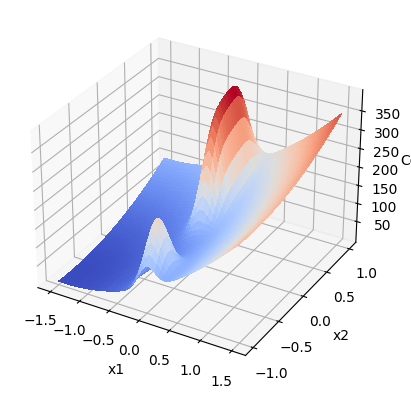

In [128]:
goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

#Visualizziamo il costo come superfcie 3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x0 = np.linspace(-1.5, 1.5, 300)
x1 = np.linspace(-1, 1, 200)
X1, X2 = np.meshgrid(x0, x1)
costs = np.array([[state_cost((a,b),goal_points,obs_points) for a in x0] for b in x1] )
costs = costs.squeeze()
surf = ax.plot_surface(X1, X2, costs, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("Cost")
plt.show()
ax = fig.add_subplot()

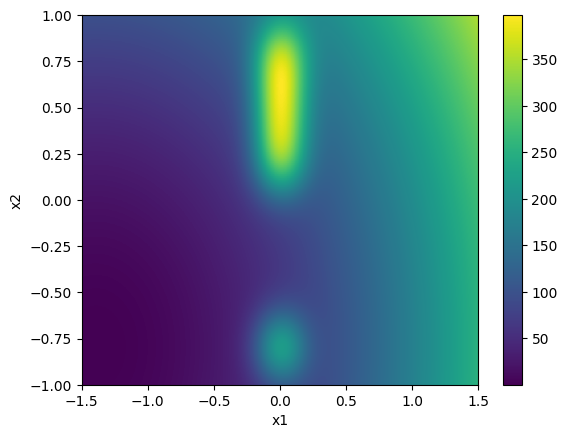

In [130]:
#Visualizziamo il costo come heatmap
import matplotlib
fig, ax = plt.subplots()
ax.set_xlabel("x1")
ax.set_ylabel("x2")
im=ax.imshow(costs, cmap=matplotlib.colormaps['viridis'], extent=[-1.5,1.5,-1,1], interpolation=None,aspect="auto", origin='lower')
plt.colorbar(im)

Qua si vedono i due ostacoli fisici, uno centrato in (0, -0.8) e un altro più lungo centrato in (0, 0.5).


In [67]:
# Define goal and obstacle points
goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

In [ ]:
#WP2: Simulate (4 experiments) and visualize each robot's trajectory

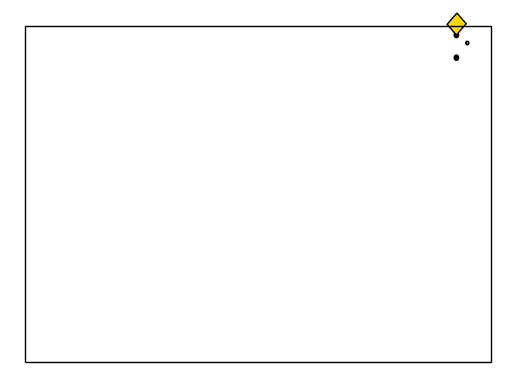

##### DEBUG OUTPUT #####
Your simulation will take approximately 51 real seconds when deployed on the Robotarium. 

	 Simulation had 6841 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

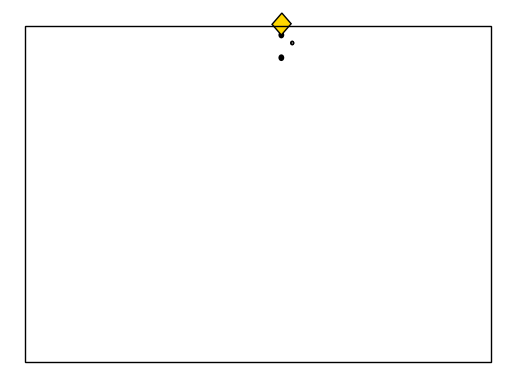

##### DEBUG OUTPUT #####
Your simulation will take approximately 42 real seconds when deployed on the Robotarium. 

	 Simulation had 7916 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

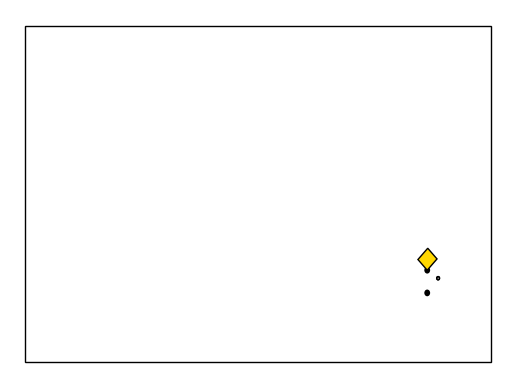

##### DEBUG OUTPUT #####
Your simulation will take approximately 35 real seconds when deployed on the Robotarium. 

	 Simulation had 8852 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

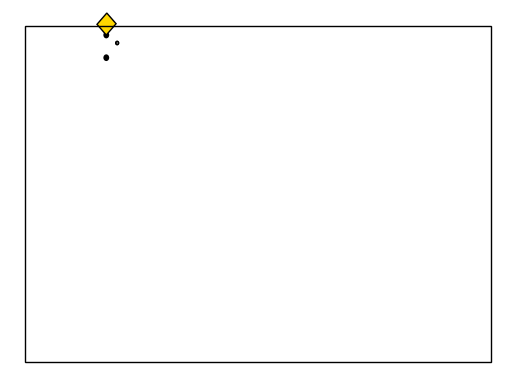

##### DEBUG OUTPUT #####
Your simulation will take approximately 33 real seconds when deployed on the Robotarium. 

	 Simulation had 9703 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [68]:
# Instantiate Robotarium object
N = 1 #Amount of robots per simulation
# Initial conditions of the robot for 4 experiments
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] #Initial pose of the robots
N_experiment = 4
# X_si is going to be two-dimensional state history
X_Si = [0]*N_experiment
# D_Xi is going to be two-dimensional inputs history
D_Xi = [0]*N_experiment

# This first for loop creates the initial conditions
for I in range(N_experiment):

    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    # Create mapping from the control inputs to the actual velocity commands to the unicycle
    # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
    _, uni_to_si_states = create_si_to_uni_mapping()
    
    # define x initially
    x = r.get_poses()
    x_si = uni_to_si_states(x)

    # Plotting Parameters
    CM = np.random.rand(N+10,3) # Random Colors
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    # Create Goal Point Markers
    #Text with goal identification
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    #Plot text for caption
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    #Text with goal identification
    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    #Plot text for caption
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()

    # While the robot is away from the objective ...
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        dxi = Control_step(x_sample, U_space_1, U_space_2, goal_points, obs_points)
        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()

    D_Xi[I] = D_xi
    X_Si[I] = X_si

    #Call at end of script to print debug information and for your script to run on the Robotarium server properly
    r.call_at_scripts_end()

In [69]:
XX = X_Si #Insieme degli stati nel sistema single-integrator (y_1, y_2) per ogni simulazione
UU = D_Xi #Insieme delle azioni di controllo per ogni simulazione

In [70]:
#Prepare data for plotting
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i])) #X=XX ma è un array di array numpy
    X_plot.append(np.array(XX[i])) #X_plot = XX ma è un array numpy
X = np.concatenate(X, axis=0) #X adesso è un array numpy. La prima dimensione contiene le traiettorie di tutti gli esperimenti concatenate e la secoda indicizza lo stato
print(X.shape)
X = np.reshape(X, (-1, 2)) # Rimuove l'ultima dimensione inutile
U = []
for i in range(len(UU)):
    U.append(np.array(UU[i])) #U=UU ma è un array di array numpy
    U_plot.append(np.array(UU[i])) #U_plot=UU ma è un array di array numpy

U = np.concatenate(U, axis=0) #Stessa cosa di prima per le traiettorie di ingresso
U = np.reshape(U, (-1, 2))

(4809, 2, 1)


In [71]:
print(len(X_Si))
[print(len(X_Si[I])) for I in range(4)]
print(len(X_Si[I][0]))
print(len(X_Si[I][0][0]))

4
1540
1245
1048
976
2
1


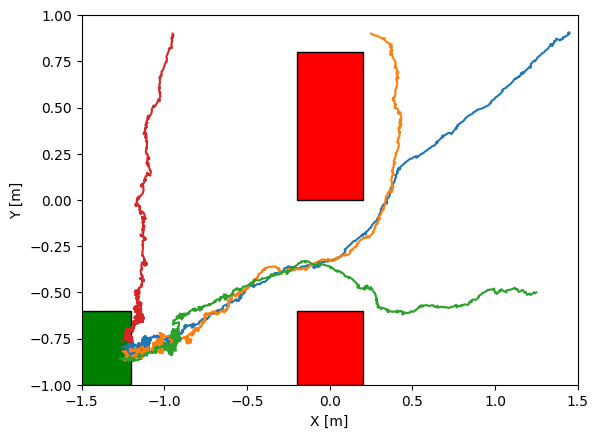

In [72]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#Task: plot trajectories with different colors

for I in range(4):
    trajectory = np.array(X_Si[I])
    plt.plot(trajectory[:,0],trajectory[:,1])
#Draw obstacles
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black") # Obiettivo da raggiungere
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black") # Ostacolo 1
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black") # Ostacolo 2
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.savefig('Training_Trajectories.jpg',dpi=1000,bbox_inches ='tight')

In rosso si vedono i due ostacoli fisici, uno centrato in (0, -0.8) e un altro più lungo centrato in (0, 0.5).
In verde si vede approssimativamente il goal point, che nella funzione costo è una forma quadratica centrata in (-1.4, -0.8)

In [ ]:
##### WP3: Reverse engineer the features and visualize them #####

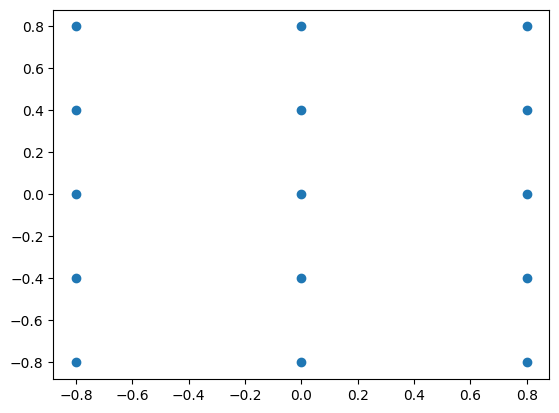

In [73]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))
obs_points_f.shape

plt.scatter(obs_points_f[0,:],obs_points_f[1,:])

In [75]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1 #16

# Le feature sono 16:
# - La prima modella il goal point
# - Altre 15 modellano potenziali ostacoli

# Da come la funzione 'feature' verrà chiamata si deduce che la posizione degli ostacoli è ignota ma il goal point è noto.

# Valuta il vettore di features [h(x_k)] nello stato x_k 
def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32) #vettore delle varianze
    covar = np.diag(v) #matrice di varianze e covarianze
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar) #Modelliamo gli ostacoli come multivariate gaussiane indipendenti (cov=0) centrate nell'ostacolo ipotizzato

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))

    return features

In [76]:
##### WP4: using the previously defined features solve the inverse optimal control problem. 
#          Plot the estimated cost. 
#          Verify that the estimated cost allows the robot to complete the task #####

In [109]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1 #size è la lunghezza di tutte le simulazioni concatenate. Concatenare le simulazioni genera 4 termini spuri.
w = cp.Variable((1,N_feature)) #Variabili decisionali. Sono tante quanto il numero di features.
constraints = [w >= 0] #Per hp del problema.
R = np.zeros((99,1)) #??? Mai usato
L = [] #Termini della funzione target da minimizzare (la funzione da minimizzare sum(L))

f_expect = np.zeros((2,20)) #???
feature_sampled = np.zeros((N_feature,M)) #Questo è il valore atteso a sinistra in blu (tranne la moltiplicazione per w che si può portare fuori)
PF = np.zeros((control_space_size,control_space_size,M)) #Questa è la funzione q soprasegnato indicizzata in (u_k, k) dove k è l'indice temporale

for i in range(M): #i è l'i-esimo termine della funzione target da ottimizzare (somma da 1 a M), sto fissando x hat 

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size)) #Questo è il valore atteso a destra in verde (tranne la moltiplicazione per w che si può portare fuori)
    state = np.array(X[i,:]) #Get the state \hat x_k-1

    x0 = state.reshape(-1,1) #è equivalente alla flatten(), x0 è lo stato iniziale (x0[0],x0[1])
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf \overline q(u)

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov) #p(x_k|\hat x_k-1, u_k) valutata per \hat x_k-1 e u_k fissati
            #next_sample = f.mean #next_sample = next_state, inutile

            N_samples = 5
            next_samples = f.rvs(N_samples) #5 campioni relativi al prossimo stato. Dimensione 5 campioni x 2 variabili di stato
            feature_sample = np.zeros((N_feature,N_samples)) # 16 feature x 5 campioni

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature) #feature_sample è una matrice che tiene sulle colonne le valutazioni delle features sui campioni. Le colonne rorrispondono ai campioni.

            features[:,j,k] = np.mean(feature_sample,axis=1) #la media è fatta su tutti gli elementi della riga [i,;], ovvero per ogni feature i-esima faccio la media su tutti i campioni
            #Alla fine del ciclo features contiene la stima del valore atteso delle features per ogni possibile ingresso (j,k) con \hat x_k-1 fissato
            #quindi ho tutte le stime dei valori attesi a destra in verde nell'equazione. Fatta con la legge dei grandi numeri.
            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = (1/control_space_size**2)*np.exp(-(-f.entropy()+np.log(6))) #notion
            pf[j,k] = log_DKL
    PF[:,:,i] = pf #q(u_k,x_k-1) per ogni u_k e per ogni \hat x_k-1

    features = np.reshape(features,(N_feature,control_space_size**2)) # Adesso features ha come primo indice la feature e il secondo va da 0 a 8 e indica l'ingresso di controllo

    f_sampled = model_step(state,U[i+1,:],time_step) # Costuiramo la pdf p(x_k|\hat x_k-1,\hat u_k) che serve a calcolare il valore atteso a sinistra in blu
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov) #p(x_k|\hat x_k-1,\hat u_k)
    next_samples_f1 = f1.rvs(N_samples) #stessa cosa di prima, stima con legge dei grandi numeri del expectation blu
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)  # features_sampled è la stessa cosa di features fatta sul valore atteso blu. nota che u è fissata qunidi non ho come indici j e k. Ho i come indice ed è inutile.

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    # (ii) sum all the elements to define the cost function
    # (iii) solve the problem
    PF2 = np.reshape(PF,(-1,M))
    l = -(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w@features,(control_space_size**2,)) + cp.log(PF2[:,i])) #(i)
    L.append(l) #(ii)

objective = cp.Minimize(cp.sum(L)) #(iii)

prob = cp.Problem(objective)

result = prob.solve(verbose = True)

print("status:", prob.status)
print("optimal value", prob.value)


ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.860e+05  +1e+05  5e-01  3e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  -1.538e+04  -9.232e+04  +5e+04  2e-01  1e+00  4e-01  4e-01  0.6266  5e-02   1  1  0 |  2  2
 2  -1.984e+04  -7.043e+04  +4e+04  8e-02  7e-01  3e-01  3e-01  0.5013  3e-01   1  0  0 |  5  3
 3  -2.277e+04  -5.710e+04  +2e+04  5e-02  5e-01  2e-01  2e-01  0.9791  7e-01   1  1  1 |  9  0
 4  -2.588e+04  -4.184e+04  +1e+04  2e-02  2e-01  9e-02  8e-02  0.6266  1e-01   1  0  1 |  3  2
 5  -2.756e+04  -3.456e+04  +4e+03  1e-02  1e-01  4e-02  3e-02  0.6266  7e-02   1  1  0 |  2  2
 6  -2.798e+04  -3.251e+04  +3e+03  7e-03  7e-02  3e-02  2e-02  0.6266  4e-01   1  0  1 |  5  2
 7  -2.820e+04  -3.128e+04  +2e+03  5e-03  4e-02  2e-02  1e-02  0.9791  6e-01   1  1  0 |  8  0
 8  -2.835e+04  -3.055e+04  +1e+03  4e-03  3e

In [115]:
w.value

array([[-11.44851784,  -6.10603973,  -0.21224049,  -1.07998478,
        -11.80304614,  -8.30004337,  -1.34379058,  -0.29121702,
         -0.11446259,   0.42491125,  -1.60148908,   0.02126046,
          0.25596844,   0.91702824,   0.30649894,  -0.31308993]])

In [116]:
np.save('weights.npy',np.array(w.value))

In [117]:
# Show the values: critically discuss if these weights make sense
weights = w.value

print('weights:',weights)

weights: [[-11.44851784  -6.10603973  -0.21224049  -1.07998478 -11.80304614
   -8.30004337  -1.34379058  -0.29121702  -0.11446259   0.42491125
   -1.60148908   0.02126046   0.25596844   0.91702824   0.30649894
   -0.31308993]]


In [118]:
# Check the status of the optimization problem: did the optimization go well? Si
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value -28738.109678055385


In [120]:
# Reformatting the original cost map (just for checking and plotting purposes)

import numpy as np
import scipy.stats as st
import pandas as pd

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

#obs_points = np.array(np.mat('0 0 0 0 0 0;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points)

Coat_Map = pd.DataFrame(Cost_Map,index=list(X_axis),columns=Y_axis)

In [121]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

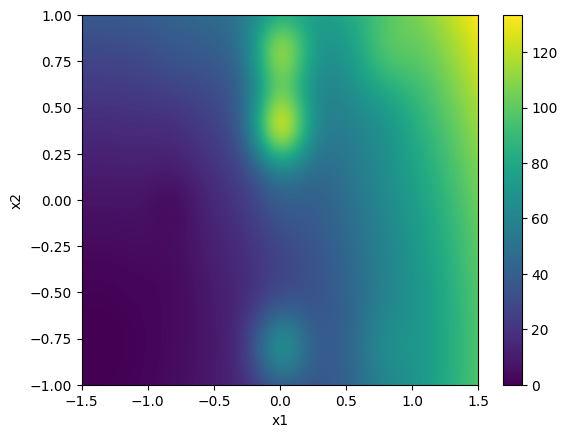

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)

# Task: plot the reconstructed cost
fig, ax = plt.subplots()
ax.set_xlabel("x1")
ax.set_ylabel("x2")
im=ax.imshow(data_rotated, cmap=matplotlib.colormaps['viridis'], extent=[-1.5,1.5,-1,1], interpolation=None,aspect="auto", origin='lower')
plt.colorbar(im)

Controllare se il fattore 6 ha influito sui valori del costo!!!!!

In [131]:
#Task: re-define the function Control_step so that it now uses the estimated cost
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
    ###
    # Perform a control step given the fact that the target pf is uniform.
    # The function first gets the target pf (uniform) and then applies the control solution we saw in class
    
    target_pf = 1/control_space_size**2 # Uniform pf q(u_k|x_k-1)
    time_step = 0.033 # The Robotarium time-step

    pf = np.zeros((control_space_size,control_space_size))
    for i in range(control_space_size):
        for j in range(control_space_size):
            next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            N_samples = 20
            next_sample = f.rvs(N_samples) 

            # Task: what do the next three lines do?
            # Calcola una stima del valore atteso del costo nello stato successivo rispetto alla funzione f(x_k|x_k-1,u_k) usando 20 campioni
            cost=0
            for k in range(N_samples):
                cost += state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
            log_DKL = np.exp(f.entropy()-cost)
            pf[i,j] = log_DKL 
    # Task: obtain the normalizer for the policy, call it S2
    S2 = np.sum(pf)
    # Task: obtain the normalized pf (call the variable pf)
    pf = np.divide(pf,S2)

    # Adesso abbiamo p(u_k|x_{k-1}) e facciamo il sampling della prossima azione di controllo
    # This is a trick to properly sample from the multi-dimensional pf
    flat = pf.flatten()
    sample_index = np.random.choice(a=flat.size, p=flat)
    # Take this index and adjust it so it matches the original array
    adjusted_index = np.unravel_index(sample_index, pf.shape) #Indice dell'azione

    #Formatta l'azione come vettore colonna
    action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))
    return(action)

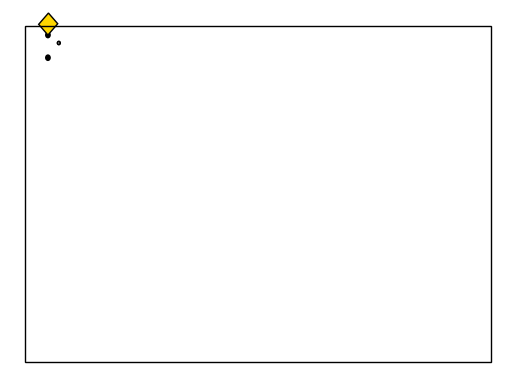

##### DEBUG OUTPUT #####
Your simulation will take approximately 66 real seconds when deployed on the Robotarium. 

	 Simulation had 11370 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

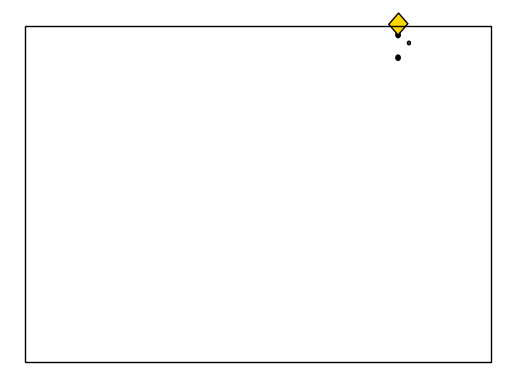

##### DEBUG OUTPUT #####
Your simulation will take approximately 149 real seconds when deployed on the Robotarium. 

	 Simulation had 15212 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

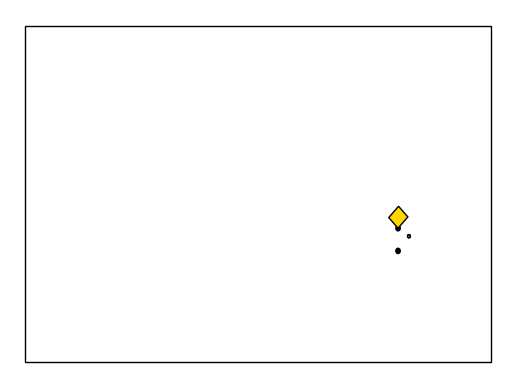

##### DEBUG OUTPUT #####
Your simulation will take approximately 146 real seconds when deployed on the Robotarium. 

	 Simulation had 18966 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [133]:
# Instantiate Robotarium object (start the robots from different initial conditions than the 4 experiments above)
N = 1
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]
N_experiment = 3
# Definitions as above...
X_Si = [0]*N_experiment
D_Xi = [0]*N_experiment

for I in range(N_experiment):

    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    x = r.get_poses()
    x_si = uni_to_si_states(x)

    CM = np.random.rand(N+10,3) 
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
    # Task: re-implement the simulation loop this time using the policy with the estimated cost
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):
        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        dxi = Control_step(x_sample, U_space_1, U_space_2, goal_points, obs_points)
        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
      

    D_Xi[I] = D_xi
    X_Si[I] = X_si

    r.call_at_scripts_end()

In [134]:
XX = X_Si
UU = D_Xi

In [135]:
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

Text(0, 0.5, 'Y [m]')

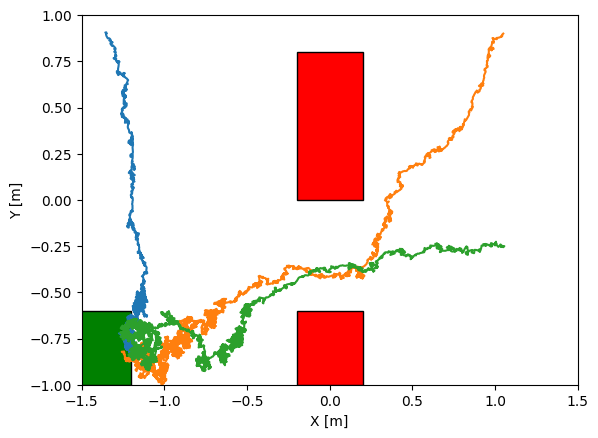

In [137]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

# Task: Plot robot trajectories (when the policy uses the reconstructed cost)
for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.plot(trajectory[:,0],trajectory[:,1])

#Draw obstacles
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

In [138]:
np.save('X_Si.npy',X_Si)
np.save('D_Xi.npy',D_Xi)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
# Task: plot the feature points on the robotarium grid with correspopnding weights

import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# Comment the results you observe in the figure generated by the above cell